Используя библиотеку Natasha извлечь все названия организаций и адреса из текстов новостей. Построить граф социальной сети для организаций, упоминавшихся в новостях, считая, что организация и адрес, встретившиеся в одной заметке связаны между собой.Найти наиболее вероятные адреса организаций.

Импортируем нужные модули

In [185]:
from bs4 import BeautifulSoup
import requests
import re
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, NewsNERTagger, PER, NamesExtractor, AddrExtractor, Doc

In [186]:
%matplotlib notebook
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
from tqdm import tqdm

Делаем суп из html со ссылки на сайт

In [187]:
url = "http://izvestiaur.ru/news/?PAGEN_1="

def get_page(j):
    url = "http://izvestiaur.ru/news/?PAGEN_1="
    new_url = url + str(j)
    response = requests.get(new_url)
    soup = BeautifulSoup(response.text)
    
    return soup

Ищем ссылки на новости, приводим их к нужному виду.

In [188]:
def get_links(soup):
    a_elems = soup.find_all('a')

    links = []
    normal_links = []
    
    for elem in a_elems:
        match = re.search(r'/news/view/\d+', elem["href"])
        if match and elem["href"] not in links:
            links.append(elem["href"])
    for link in links:
        normal_link = re.search(r'http://www.izvestiaur.ru/news/view/\d+', link)
        if normal_link:
            normal_links.append(link)
        if not normal_link:
            link = 'http://www.izvestiaur.ru' + link
            normal_links.append(link)
        
    return normal_links


Функция, которая достает текст статьи по ссылке.

In [189]:
def get_article(some_url):
    response_news = requests.get(some_url)
    news_soup = BeautifulSoup(response_news.text)
    news_text = news_soup.find_all("div")
    some_article = []
    
    for elem in news_text:
        if elem.get('class') != None:
            if elem['class'] == ['article-anonce']:
                for string in elem.stripped_strings:
                    some_article.append(string)
        if elem.get('style') != None:        
            if len(elem.attrs) == 1 and elem['style'] == 'margin-top:5px;':
                for string in elem.stripped_strings:
                    some_article.append(string)
    this_article = ' '.join(some_article)

    return this_article

Достаем все тексты.

In [190]:
stats = []
for i in tqdm(range(1, 101)):
    pages = get_page(i)
    urls = get_links(pages)
    for url in urls:
        stats.append(get_article(url))
        stats.append('\n***\n')


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [24:56<00:00, 14.96s/it]


Кладем тексты в файл.

In [191]:
with open('news.txt', "w", encoding = 'utf-8') as f:
    for s in stats:
        f.write(s)

Берем файл и читаем тексты.

In [193]:
with open('news.txt', encoding = 'utf-8') as f:
    text = f.read().split('\n***\n')

Функции для работы с Natasha

In [194]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

Функция для поиска организаций в тексте

In [197]:
def name_search(some_text):
    doc = Doc(some_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        
    for span in doc.spans:
        span.normalize(morph_vocab)
        
    org_and_adr = []
    org_and_adr = [(s.normal, s.type) for s in doc.spans if s.type == 'ORG' and (s.normal, s.type) not in org_and_adr]
    for s in doc.spans:
        if s.type == 'LOC' and (s.normal, s.type) not in org_and_adr:
            org_and_adr.append((s.normal, s.type))
    
    return org_and_adr

Функция для получения названий организаций и адресов, а также связей между ними

In [200]:
def getorgs(some_text):
    orgs = {}
    connect = {}
    
    for art in tqdm(some_text):
        snam = name_search(art)
        for n in snam:
            orgs[n] = orgs.get(n, 0)+1
            pers=connect.get(n, {})
            for n2 in snam:
                if n != n2 and n[1] != n2[1]:
                    pers[n2] = pers.get(n2, 0)+1
            connect[n] = pers
    
    return orgs, connect

In [201]:
organisations, connections = getorgs(text)

100%|██████████████████████████████████████████████████████████████████████████████| 5146/5146 [04:46<00:00, 17.95it/s]


Уменьшаем количество организаций и мест

In [245]:
org2={n:{n2:connections[n][n2] for n2 in connections[n].keys() if organisations[n2]>200 and n2!=')'}
           for n in connections.keys() if organisations[n]>200 and n!=')'}
org2

{('Ижевск', 'LOC'): {('Covid-19', 'ORG'): 106,
  ('Удмуртская Республика', 'ORG'): 333,
  ('ВКонтакте', 'ORG'): 248,
  ('Роспотребнадзор', 'ORG'): 208,
  ('МВД', 'ORG'): 712,
  ('ГКБ', 'ORG'): 303,
  ('ИП', 'ORG'): 200,
  ('Минздрав', 'ORG'): 200,
  ('Городская дума', 'ORG'): 1016,
  ('Гордума', 'ORG'): 399,
  ('Единая Россия', 'ORG'): 312,
  ('Центр территориального развития', 'ORG'): 302,
  ('Росавиация', 'ORG'): 307,
  ('Аэрофлот', 'ORG'): 3,
  ('Госавтоинспекция', 'ORG'): 27,
  ('Instagram', 'ORG'): 2,
  ('Школа', 'ORG'): 3,
  ('ВТБ', 'ORG'): 10},
 ('Удмуртия', 'LOC'): {('ВКонтакте', 'ORG'): 453,
  ('Instagram', 'ORG'): 203,
  ('Covid-19', 'ORG'): 208,
  ('Роспотребнадзор', 'ORG'): 325,
  ('Удмуртская Республика', 'ORG'): 334,
  ('МВД', 'ORG'): 995,
  ('Госавтоинспекция', 'ORG'): 238,
  ('ГКБ', 'ORG'): 306,
  ('Россельхознадзор', 'ORG'): 201,
  ('Минздрав', 'ORG'): 406,
  ('ИП', 'ORG'): 201,
  ('Городская дума', 'ORG'): 512,
  ('Гордума', 'ORG'): 300,
  ('Единая Россия', 'ORG'): 21

Функция построения графа

In [246]:
def form_a_graph(orgs_and_addrs):
    G=nx.Graph()
    for n in orgs_and_addrs.keys():
        for n2 in orgs_and_addrs[n].keys():
            G.add_edge(n, n2)
            
    return G

In [247]:
G1 = form_a_graph(org2)

In [252]:
def draw_a_graph(G, orgs_and_addrs, freqs, colors = 'b', layout = 'spring'):
    if layout=='kawai':
        pstn=nx.kamada_kawai_layout(G)
    elif layout=='circle':
        pstn=nx.drawing.layout.circular_layout(G2)
    elif layout=='random':
        pstn=nx.drawing.layout.random_layout(G2)
    else:
        pstn=nx.spring_layout(G)
        
    sz=[freqs[n] for n in G.nodes]  
    
    lw=[math.log(orgs_and_addrs[e[0]][e[1]], 10)+1 for e in G.edges]
    
    nx.draw(G, pos=pstn, node_color=colors, edge_color='g', with_labels=True, node_size=sz, width=lw);

<IPython.core.display.Javascript object>


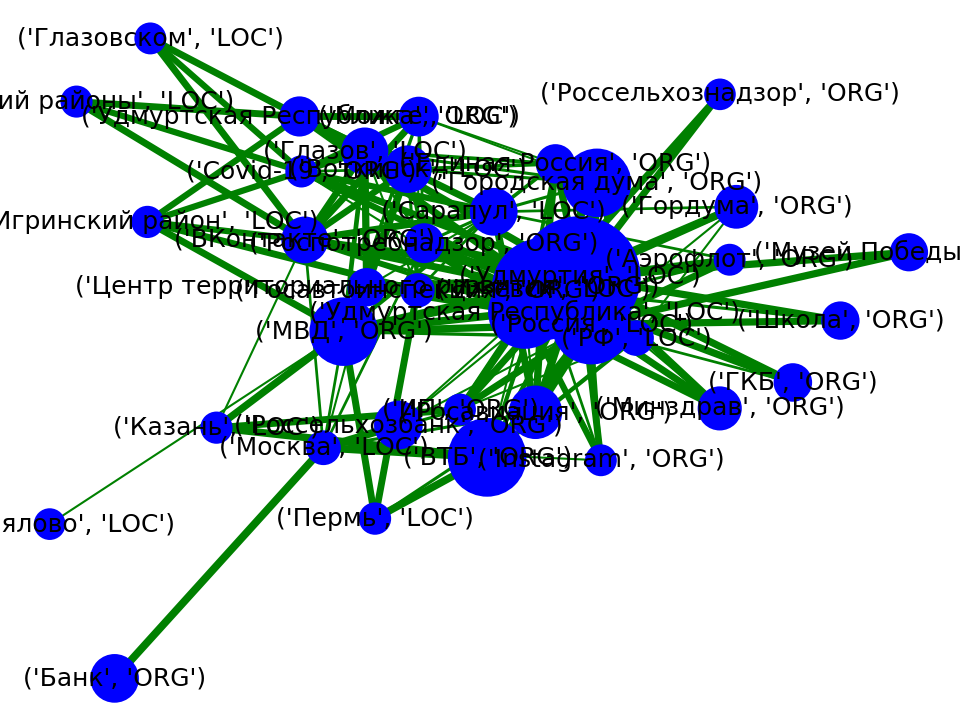

In [253]:
draw_a_graph(G1, org2, organisations)